In [1]:
from pathlib import Path
from tqdm.notebook import tqdm
from tabulate import tabulate
import random, json
import pycountry
from iso639 import languages
import networkx as nx
from dateutil import parser
from datetime import datetime
from collections import Counter
from langdetect import detect
from omnibelt import load_json, save_json

In [2]:
lang_clusters = {'en': ['au', 'ca', 'gb', 'ie', 'in', 'my', 'ng', 'nz', 'ph', 'sa', 'sg', 'us', 'za'], 'es': ['ar', 'co', 'cu', 'mx', 've'], 'de': ['at', 'ch', 'de'], 'fr': ['be', 'fr', 'ma'], 'zh': ['cn', 'hk', 'tw'], 'ar': ['ae', 'eg'], 'pt': ['br', 'pt'], 'bg': ['bg'], 'cs': ['cz'], 'el': ['gr'], 'he': ['il'], 'hu': ['hu'], 'id': ['id'], 'it': ['it'], 'ja': ['jp'], 'ko': ['kr'], 'lt': ['lt'], 'lv': ['lv'], 'nl': ['nl'], 'no': ['no'], 'pl': ['pl'], 'ro': ['ro'], 'ru': ['ru'], 'sv': ['se'], 'sl': ['si'], 'sk': ['sk'], 'sr': ['rs'], 'th': ['th'], 'tr': ['tr'], 'uk': ['ua']}
loc_names = {'gb': 'United Kingdom', 'ar': 'Argentina', 'pl': 'Poland', 'sk': 'Slovakia', 'us': 'United States', 'eg': 'Egypt', 'no': 'Norway', 'ph': 'Philippines', 'at': 'Austria', 'rs': 'Serbia', 'tw': 'Taiwan', 'be': 'Belgium', 'cu': 'Cuba', 'sa': 'Saudi Arabia', 'th': 'Thailand', 'id': 'Indonesia', 'ru': 'Russian Federation', 'ch': 'Switzerland', 'fr': 'France', 'lt': 'Lithuania', 'tr': 'Turkey', 'de': 'Germany', 'cz': 'Czechia', 'pt': 'Portugal', 'ae': 'United Arab Emirates', 'it': 'Italy', 'cn': 'China', 'lv': 'Latvia', 'nl': 'Netherlands', 'hk': 'Hong Kong', 'ca': 'Canada', 'br': 'Brazil', 'hu': 'Hungary', 'kr': 'Korea', 'si': 'Slovenia', 'au': 'Australia', 'my': 'Malaysia', 'ie': 'Ireland', 'ua': 'Ukraine', 'in': 'India', 'ma': 'Morocco', 'bg': 'Bulgaria', 'ng': 'Nigeria', 'il': 'Israel', 'se': 'Sweden', 'za': 'South Africa', 've': 'Venezuela', 'nz': 'New Zealand', 'jp': 'Japan', 'sg': 'Singapore', 'gr': 'Greece', 'mx': 'Mexico', 'co': 'Colombia', 'ro': 'Romania'}
lang_names = {'en': 'English', 'ko': 'Korean', 'ru': 'Russian', 'es': 'Spanish', 'pt': 'Portuguese', 'cs': 'Czech', 'tr': 'Turkish', 'nl': 'Dutch', 'ar': 'Arabic', 'fr': 'French', 'bg': 'Bulgarian', 'id': 'Indonesian', 'sk': 'Slovak', 'el': 'Greek', 'he': 'Hebrew', 'sr': 'Serbian', 'hu': 'Hungarian', 'th': 'Thai', 'zh': 'Chinese', 'no': 'Norwegian', 'sl': 'Slovenian', 'sv': 'Swedish', 'de': 'German', 'lv': 'Latvian', 'pl': 'Polish', 'it': 'Italian', 'ro': 'Romanian', 'lt': 'Lithuanian', 'ja': 'Japanese', 'uk': 'Ukrainian'}
cluster_id = {loc: lang for lang, locs in lang_clusters.items() for loc in locs}
len(cluster_id)

54

In [3]:
def show_date(date):
	return date.strftime('%d %b%y')
def get_locs(article):
	return [f'{loc_names[loc]}' for loc in sorted(set(i['location'] for i in article['instances']))]
def get_cats(article):
	return [f'<{cat}>' for cat in sorted(set(i['category'] for i in article['instances']))]
def view_article(art, detailed=False):
	cats = ' '.join(get_cats(art))
	locs = ', '.join(map(repr,get_locs(art)))
	published = parser.parse(art['publishedAt'])
	collected = [parser.parse(i['collectedAt']) for i in art['instances']]
	first = min(collected)
	last = max(collected)
	timing = f'{show_date(first)}' if first==last else f'{show_date(first)} - {show_date(last)}'
	
	lines = []
	if 'en-title' in art:
		lines.append(f'English Title: {art["en-title"]!r}')
	lines.append(f'{lang_names[art["language"]]} Title: {art["title"]!r}')
	lines.append(f'Categories: {cats}  ---   {locs} ({timing})')
	
	if detailed:
		added_desc = False
		desc = art.get('description')
		en_desc = art.get('en-description')
		if en_desc is not None and len(en_desc):
			lines.append(f'English Description: {en_desc}')
			added_desc = True
		if desc is not None and len(desc):
			lines.append(f'{lang_names[art["language"]]} Description: {desc}')
			added_desc = True
		if not added_desc:
			lines.append(f'- No description -')
	print('\n'.join(lines))

In [12]:
root = Path('/home/fleeb/workspace/local_data/nnn')
recs = (root/'old-bb-v1').glob('**/*.json')
recs = (root/'babel-briefings-v1').glob('**/*.json')
recs = list(recs)
len(recs)

54

In [13]:
articles = []
for rec in tqdm(recs):
	articles.extend(load_json(rec))
len(articles)

  0%|          | 0/54 [00:00<?, ?it/s]

4719199

In [14]:
by_loc = {}
by_lang = {}
for article in tqdm(articles):
	# article['published'] = parser.parse(article['publishedAt'])
	by_lang.setdefault(article['language'], []).append(article)
	for instance in article['instances']:
		# instance['collected'] = parser.parse(instance['collectedAt'])
		by_loc.setdefault(instance['location'], []).append(article)
len(by_loc), len(by_lang)

  0%|          | 0/4719199 [00:00<?, ?it/s]

(54, 30)

In [15]:
# dstroot = root / 'babel-briefings-v1'
# dstroot.mkdir(exist_ok=True)

In [16]:
# first_mention = {}
# past = set()
# for i, art in tqdm(enumerate(sorted(articles, key=lambda a: (a['instances'][0]['collectedAt'], '' if a.get('publishedAt', '') is None else a.get('publishedAt', '')))), total=len(articles)):
# 	oldID = art['ID']
# 	if oldID in past:
# 		continue
# 	past.add(oldID)
# 	art['ID'] = i
# 	first_mention.setdefault(art['instances'][0]['location'], []).append(art)
# len(first_mention)

In [17]:
# sum(len(v) for v in first_mention.values())

In [18]:
# for loc, arts in tqdm(first_mention.items()):
# 	rec = dstroot / f'babel-briefings-v1-{loc}.json'
# 	rec.write_text(json.dumps(arts), encoding='utf8')

In [33]:
art = random.choice(articles)
view_article(art, detailed=True)

English Title: 'Will Smith had a harem list - Hollywood star was on it - Express.de'
German Title: 'Will Smith hatte eine Harems-Liste – Hollywood-Star stand drauf - Express.de'
Categories: <entertainment>  ---   'Germany' (30 Sep21)
English Description: Will Smith opened up about his marriage to Jada Pinkett Smith in an interview. There have been crises - and new ways to stay together.
German Description: Will Smith hat in einem Interview offen über seine Ehe mit Jada Pinkett Smith gesprochen. Es habe Krisen gegeben – und neue Wege, um zusammenzubleiben.


In [34]:
# print(tabulate([(key, len(val)) for key, val in sorted(by_lang.items(), key=lambda x: len(x[1]), reverse=True)]))
print(tabulate([(lang_names[key], len(val)) for key, val in sorted(by_lang.items(), key=lambda x: len(x[1]), reverse=True)]))

----------  -------
English     1128233
Spanish      455952
French       288328
Chinese      270887
German       259718
Portuguese   243829
Arabic       178854
Indonesian   131252
Italian      129005
Turkish      122724
Greek        119940
Japanese     118475
Polish       116904
Russian      113395
Dutch        104031
Thai          90708
Swedish       86838
Korean        83090
Serbian       80040
Hungarian     73509
Czech         70647
Hebrew        67794
Bulgarian     67223
Ukrainian     65610
Romanian      54601
Norwegian     46804
Slovak        43057
Latvian       40006
Lithuanian    34719
Slovenian     33026
----------  -------


In [35]:
langs = Counter(art['language'] for art in articles)
len(langs)

30

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/tmp/ipykernel_33199/1681776673.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Language', data=df, palette='viridis')


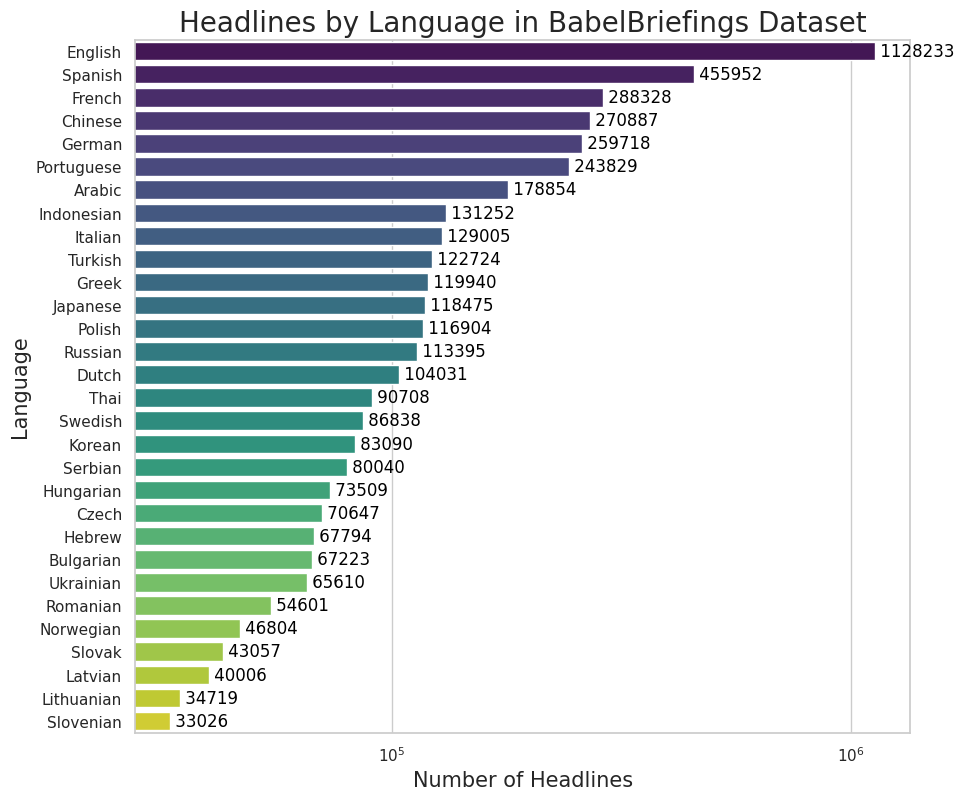

In [51]:
show_top = 30

lang_dict = {}
rest = 0

for i, (l, n) in enumerate(langs.most_common()):
	if i < show_top:
		lang_dict[lang_names[l]] = n
	else:
		rest += n
if rest:
	lang_dict['Other'] = rest

# Sample dictionary. Replace this with your actual data.
# lang_dict = dict(lc.most_common(20))

# Convert the dictionary into a DataFrame
df = pd.DataFrame(list(lang_dict.items()), columns=['Language', 'Count'])

# Sort the DataFrame by Count
# df = df.sort_values('Count', ascending=False)

# Create a bar plot
fg = plt.figure(figsize=(10, 9))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='Count', y='Language', data=df, palette='viridis')

# Add labels and title
plt.xlabel('Number of Headlines', fontsize=15)
plt.ylabel('Language', fontsize=15)
plt.title('Headlines by Language in BabelBriefings Dataset', fontsize=20)

# Annotate the bars with the actual counts
for index, value in enumerate(df['Count']):
    ax.text(value, index, f' {value}', color='black', va="center", fontsize=12)

plt.xscale('log');

# Show the plot
# plt.show()

In [53]:
fg.savefig(root/'assets'/'lang-dist.png', bbox_inches='tight');

In [55]:

df = pd.DataFrame([{'language': art['language'], 
					'language_name': lang_names[art['language']], 
					'loc_name': loc_names[ins['location']], 
					**ins} for art in articles for ins in art['instances']])

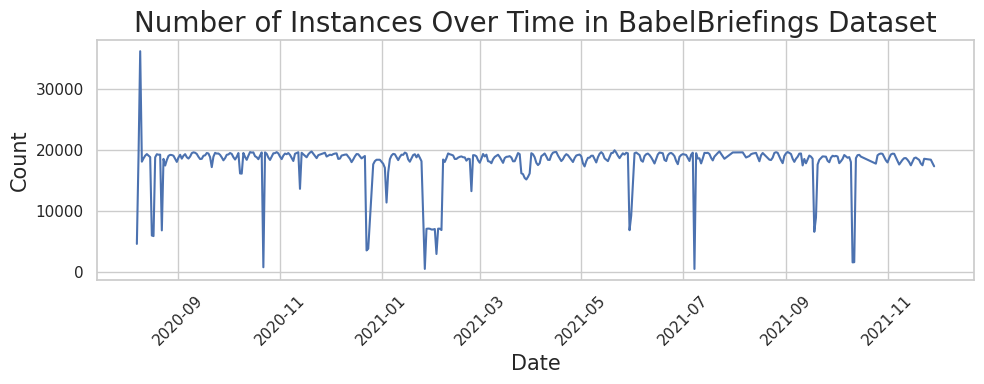

In [56]:

# Extracting the 'collectedAt' and 'category' fields and converting 'collectedAt' to datetime
df['date'] = pd.to_datetime(df['collectedAt'])
df['date'] = df['date'].dt.date  # Extracting just the date part

# Counting the number of samples per day per category
counts = df.groupby(['date', 'category']).size().reset_index(name='count')

# Pivoting the data to get categories as columns and dates as rows
pivot_counts = counts.pivot(index='date', columns='category', values='count').fillna(0)

# N = 3  # You can change this value as per your need
# pivot_counts = pivot_counts.iloc[N:]

# Plotting the data
fg = plt.figure(figsize=(10, 4))
# for category in pivot_counts.columns:
#     plt.plot(pivot_counts.index, pivot_counts[category], label=category)

totals = pivot_counts.sum(axis=1)
plt.plot(pivot_counts.index, totals)  #, label='Total')

# Adding labels and legend
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Number of Instances Over Time in BabelBriefings Dataset', fontsize=20)
plt.xticks(rotation=45)
# plt.legend(title='Category')

# Display the plot
plt.tight_layout()
plt.grid(True)


In [57]:
fg.savefig(root/'assets'/'total-counts.png', bbox_inches='tight');

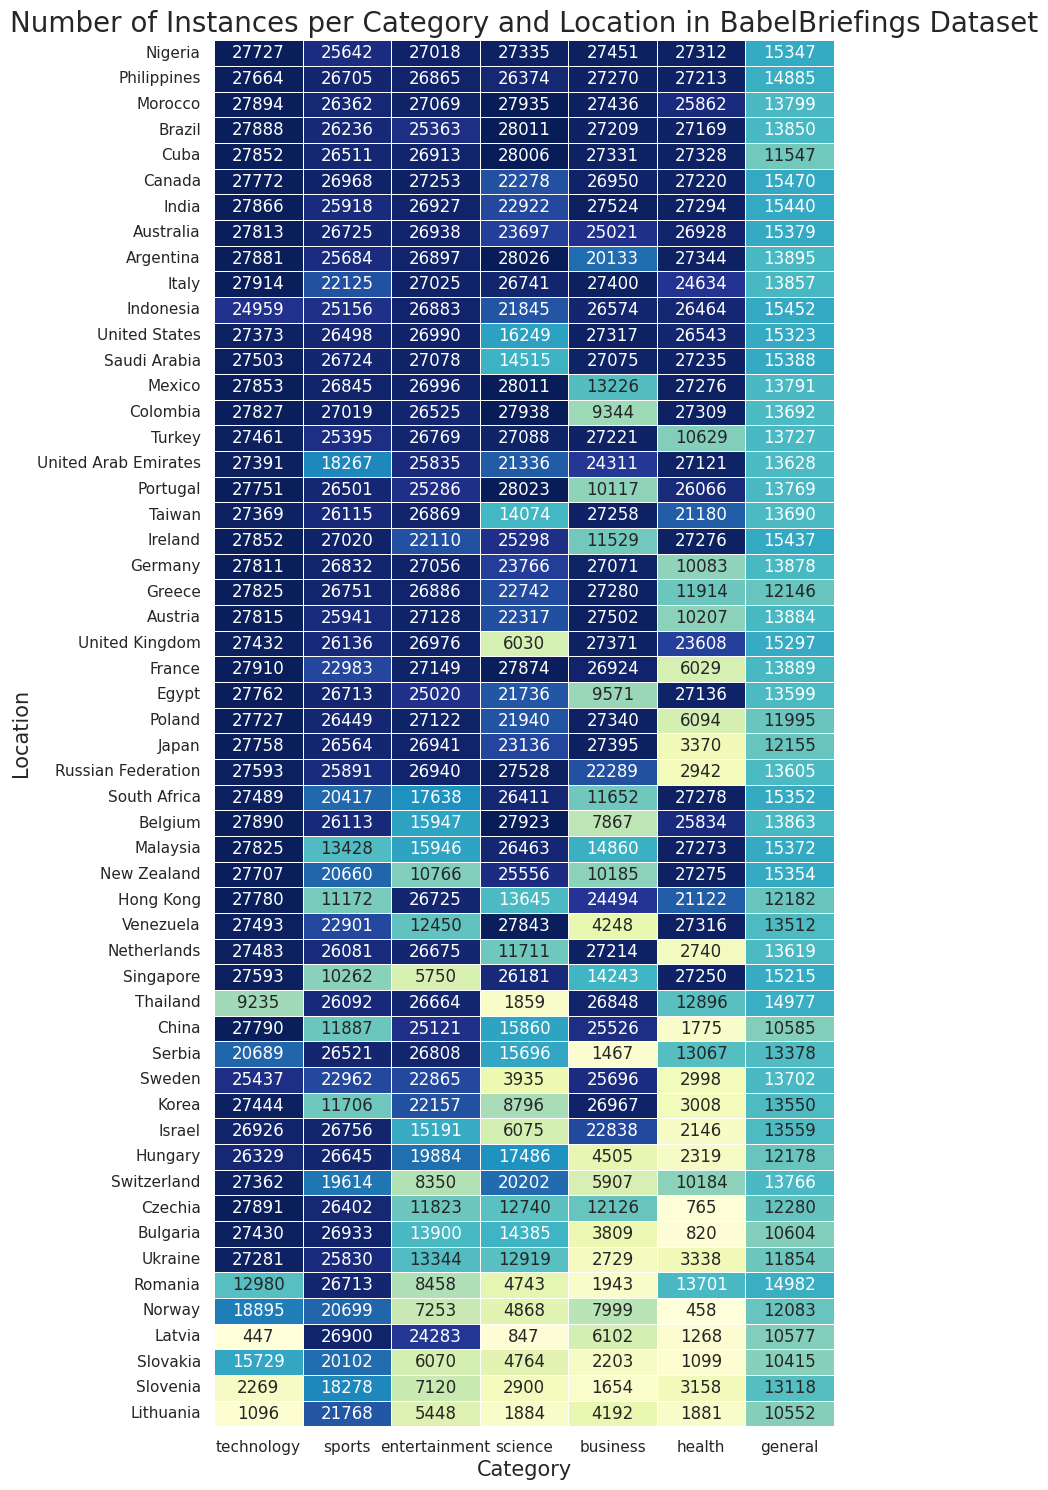

In [58]:
pivot_table = pd.pivot_table(df, index='loc_name', columns='category', aggfunc='size', fill_value=0)
# pivot_table = pd.pivot_table(df, index='language_name', columns='category', aggfunc='size', fill_value=0)
sorted_columns = pivot_table.sum().sort_values(ascending=False).index
sorted_rows = pivot_table.sum(axis=1).sort_values(ascending=False).index
pivot_table = pivot_table.loc[sorted_rows, sorted_columns]
fg = plt.figure(figsize=(8, 18))
# plt.figure(figsize=(18, 8))

# Create a heatmap
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5, cbar=False)

# Add labels and title
plt.xlabel('Category', fontsize=15)
plt.ylabel('Location', fontsize=15)
plt.title('Number of Instances per Category and Location in BabelBriefings Dataset', fontsize=20);

# Show the plot
# plt.show()


In [59]:
fg.savefig(root/'assets'/'loc-cat-mat.png', bbox_inches='tight');